In [1]:
import pandas as pd
import glob
import os
import subprocess
import re
import numpy as np
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster import hierarchy
from skbio.diversity import beta_diversity
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(' ','_',x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

bigscape_df = get_bigscape_df("./bigscape_outputs/bigscape_all_c030.txt")

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,PXPV01000027.1.region001,PXPY01000236.1.region001,0.115125,0.783004,1.000000,0.884260,0.857143,0.115740,0.0,12,0,siderophore - siderophore,siderophore
1,AJLL01000049.1.region001,NGZT01000062.1.region001,0.033442,0.934235,0.928571,0.969697,0.833333,0.058824,0.0,17,4,hglE-KS.resorcinol - hglE-KS.resorcinol,hglE-KS.resorcinol
2,PXPM01000050.1.region001,PXQG01000022.1.region001,0.148245,0.725487,0.777778,0.860708,0.454545,0.139292,0.0,10,0,siderophore - siderophore,siderophore
3,QOPQ01000007.1.region001,c00035_gi1022...region001,0.267240,0.536937,0.947368,0.728130,0.850000,0.271870,0.0,24,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin
4,NHDT02000030.1.region001,SHBU01000008.1.region001,0.279188,0.519570,0.875000,0.716412,0.857143,0.283588,0.0,7,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin


In [3]:
sim_col = []

for i,r in bigscape_df.iterrows():
    similarity = 1 - float(bigscape_df['Raw_distance'].loc[i])
    sim_col.append(similarity)

bigscape_df['Raw_distance'] = sim_col
bigscape_df.rename(columns={'Raw_distance':'Similarity'}, inplace=True)

bigscape_df[:5]

,Clustername_1,Clustername_2,Similarity,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,PXPV01000027.1.region001,PXPY01000236.1.region001,0.884875,0.783004,1.000000,0.884260,0.857143,0.115740,0.0,12,0,siderophore - siderophore,siderophore
1,AJLL01000049.1.region001,NGZT01000062.1.region001,0.966558,0.934235,0.928571,0.969697,0.833333,0.058824,0.0,17,4,hglE-KS.resorcinol - hglE-KS.resorcinol,hglE-KS.resorcinol
2,PXPM01000050.1.region001,PXQG01000022.1.region001,0.851755,0.725487,0.777778,0.860708,0.454545,0.139292,0.0,10,0,siderophore - siderophore,siderophore
3,QOPQ01000007.1.region001,c00035_gi1022...region001,0.732760,0.536937,0.947368,0.728130,0.850000,0.271870,0.0,24,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin
4,NHDT02000030.1.region001,SHBU01000008.1.region001,0.720812,0.519570,0.875000,0.716412,0.857143,0.283588,0.0,7,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin


In [4]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        print("Parsing BGCs from folder %s"%antismash_folder)
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/home/jovyan/jupyterdata/tiago/cyanobiome/ncbi_antismash/nf_output/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

Parsing BGCs from folder /home/jovyan/jupyterdata/tiago/cyanobiome/ncbi_antismash/nf_output/


In [5]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

bigscape_df[:5]

,Clustername_1,Clustername_2,Similarity,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,PXPV01.region001,PXPY01.region007,0.884875,0.783004,1.000000,0.884260,0.857143,0.115740,0.0,12,0,siderophore - siderophore,siderophore
1,AJLL01.region005,NGZT01.region008,0.966558,0.934235,0.928571,0.969697,0.833333,0.058824,0.0,17,4,hglE-KS.resorcinol - hglE-KS.resorcinol,hglE-KS.resorcinol
2,PXPM01.region001,PXQG01.region001,0.851755,0.725487,0.777778,0.860708,0.454545,0.139292,0.0,10,0,siderophore - siderophore,siderophore
3,QOPQ01.region002,LVHK01.region009,0.732760,0.536937,0.947368,0.728130,0.850000,0.271870,0.0,24,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin
4,NHDT02.region001,SHBU01.region004,0.720812,0.519570,0.875000,0.716412,0.857143,0.283588,0.0,7,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin


In [6]:
def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    '''This function convert a list of group of nodes into edges
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    '''This function generate a graph using a list of group of nodes and the edges create with the function to_edges()
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file,bigscape_df):
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict)
    return gcf_dict

gcf_dict = main_get_families('./bigscape_outputs/bigscape_all_c030.txt',bigscape_df)

In [7]:
cluster_list = []
strains = []

for item in gcf_dict.values():
    cluster_list = cluster_list + item

for item in cluster_list:
    if 'BGC' in item[:3]:
        strains.append('MIBiG')
    else:
        strains.append(item.split('.')[0])

col_names = list(np.unique(strains))

col_names.remove('')

col_names

['AADV02',
 'AANO01',
 'AANP01',
 'AAOK01',
 'AAUA01',
 'AAVU01',
 'AAVW01',
 'AAXW01',
 'ABRS01',
 'ABRV01',
 'ABSE01',
 'ABYK01',
 'ACDW01',
 'ACSK03',
 'ACYA01',
 'ACYB01',
 'ADXM01',
 'AEPQ01',
 'AESD01',
 'AFJC01',
 'AFXD01',
 'AGCR01',
 'AGIK01',
 'AGIZ01',
 'AGJC02',
 'AJHB01',
 'AJLJ01',
 'AJLK01',
 'AJLL01',
 'AJLM01',
 'AJLN01',
 'AJTX02',
 'AJUS01',
 'AJUT01',
 'AJUU01',
 'AJWF01',
 'AJYB01',
 'ALPD01',
 'ALPE01',
 'ALPF01',
 'ALPH01',
 'ALPJ01',
 'ALPK01',
 'ALVI01',
 'ALVJ01',
 'ALVM01',
 'ALVN01',
 'ALVP01',
 'ALVS01',
 'ALVT01',
 'ALVU02',
 'ALVW01',
 'ALVX01',
 'ALVY01',
 'ALWA01',
 'ALWB01',
 'ALWD01',
 'ANFJ01',
 'ANFQ01',
 'ANKN01',
 'ANKQ01',
 'ANNX02',
 'AOCI01',
 'APIY01',
 'APIZ01',
 'AQPY01',
 'ASAK01',
 'ASZQ01',
 'AUMZ01',
 'AUNA01',
 'AUZM01',
 'AVFS01',
 'AVFT01',
 'AVFU01',
 'AVFV01',
 'AVFW01',
 'AVFX01',
 'AVFY01',
 'AVFZ01',
 'AWNH01',
 'AXAQ01',
 'AXUV01',
 'AXUW01',
 'AXUX01',
 'AXZO01',
 'AZXL01',
 'AZYY01',
 'BAUB01',
 'BAWS01',
 'BBPA01',
 'BBWW01',

In [8]:
family_rows = []
indexes = []

for key,value in gcf_dict.items():
    indexes.append(key)
    row = []
    for strain in col_names:
        if strain == "MIBiG":
            find_substring_in_list = [s for s in value if "BGC" in s]
            sublist = filter(lambda x: "BGC" in x, value)
            sublist = list(sublist)
        else:
            find_substring_in_list = [s for s in value if strain.lower() in s.lower()] # .lower() for case insensitive
            sublist = filter(lambda x: strain in x, value)
            sublist = list(sublist)
            for item in find_substring_in_list:
                if 'BGC' in item[:3]:
                    find_substring_in_list.remove(item)
                    sublist.remove(item)
        if find_substring_in_list:
            row.append(sublist)
        else:
            row.append(0)
    family_rows.append(row)
    
gcf_patterns = pd.DataFrame(family_rows,columns=col_names,index=indexes)

In [9]:
gcf_patterns

,AADV02,AANO01,AANP01,AAOK01,AAUA01,AAVU01,AAVW01,AAXW01,ABRS01,ABRV01,...,UCNJ01,UCNL01,UCNM01,UCNN01,UCNR01,UCNU01,UCNV01,UCNW01,UCNZ01,UCOB01
GCF1,[AADV02.region001],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF2,[AADV02.region002],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,[AADV02.region007],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF4,[AADV02.region008],0,0,0,0,0,0,[AAXW01.region005],0,0,...,0,0,0,0,0,0,0,0,0,0
GCF5,[AADV02.region010],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF1080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF1081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF1082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF1083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
family_counts = []

for i,r in gcf_patterns.iterrows():
    new_row = []
    for item in r:
        if item == 0:
            new_row.append(0)
        else:
            new_row.append(1)
    family_counts.append(new_row)
    
gcf_binary = pd.DataFrame(family_counts,columns=col_names,index=indexes)

gcf_binary[:5]

,AADV02,AANO01,AANP01,AAOK01,AAUA01,AAVU01,AAVW01,AAXW01,ABRS01,ABRV01,...,UCNJ01,UCNL01,UCNM01,UCNN01,UCNR01,UCNU01,UCNV01,UCNW01,UCNZ01,UCOB01
GCF1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# cyanobiome_list = ['JAAHII01','JAAHIH01','JAAHGF01','JAAHHC01','JAAHHD01','JAAHFN01','JAAHGM01','JAAHGB01','JAAHFW01','JAAHFZ01','JAAHFP01','JAAHGH01','JAAHGC01','JAAHGA01','JAAHHJ01','JAAHGO01','JAAHGU01','JAAHGW01','JAAHGS01','JAAHHM01','JAAHHP01','JAAHHN01','JAAHGL01','JAAHFU01']
cyanobiome_list = ['JAAHII01','JAAHIH01','JAAHHD01','JAAHGB01','JAAHFZ01','JAAHHJ01','JAAHGO01','JAAHGU01','JAAHGS01','JAAHHM01','JAAHGL01']

In [26]:
cols_to_keep = []

for item in gcf_binary.columns:
    if item in cyanobiome_list:
        cols_to_keep.append(item)

gcf_binary = gcf_binary[cols_to_keep]
gcf_binary = gcf_binary[(gcf_binary.T != 0).any()]

gcf_binary[:5]

,JAAHFZ01,JAAHGB01,JAAHGL01,JAAHGO01,JAAHGS01,JAAHGU01,JAAHHD01,JAAHHJ01,JAAHHM01,JAAHIH01,JAAHII01
GCF24,1,1,0,1,0,1,1,0,1,1,0
GCF26,1,0,0,0,1,0,1,1,1,1,0
GCF53,0,0,0,0,0,0,1,0,0,1,0
GCF54,1,0,0,0,0,0,1,0,1,1,0
GCF55,1,0,0,0,0,0,1,0,0,1,0


In [27]:
header = list(gcf_binary.columns.values)
# gcf_binary.index.names = ['GCFs']

ids = gcf_binary.columns.astype(str).tolist()
# data = gcf_binary.as_matrix()
data = gcf_binary[cols_to_keep].values
data = data.transpose()
data = data.astype(int)

bc_dm = beta_diversity('jaccard', data, ids)
bc_dm_df = bc_dm.to_data_frame()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [28]:
diversity_scores = {}

for i,r in bc_dm_df.iterrows():
    diversity_scores[i] = np.average(bc_dm_df[i]),np.std(bc_dm_df[i])

In [31]:
diversity_scores

{'JAAHFZ01': (0.7520541352092155, 0.3120292530297648),
 'JAAHGB01': (0.7956357836740612, 0.3133470339188333),
 'JAAHGL01': (0.9090909090909091, 0.28747978728803447),
 'JAAHGO01': (0.8243061334165454, 0.2745494184263408),
 'JAAHGS01': (0.8522433399438747, 0.3035874978997594),
 'JAAHGU01': (0.8023880105401844, 0.3138462183199509),
 'JAAHHD01': (0.7643506517660289, 0.31444191484797007),
 'JAAHHJ01': (0.8543080425074687, 0.30438674831785806),
 'JAAHHM01': (0.8047245470636587, 0.2735677543339288),
 'JAAHIH01': (0.7734622097270318, 0.2936925853341907),
 'JAAHII01': (0.9090909090909091, 0.28747978728803447)}

In [32]:
taxa_dict = {'JAAHII01':'Leptolyngbya',
            'JAAHIH01':'Moorea',
            'JAAHHD01':'Moorea',
            'JAAHGB01':'Okeania',
            'JAAHFZ01':'Moorea',
            'JAAHHJ01':'Symploca',
            'JAAHGO01':'Okeania',
            'JAAHGU01':'Okeania',
            'JAAHGS01':'Symploca',
            'JAAHHM01':'Moorea',
            'JAAHGL01':'Symploca'}

In [34]:
most_promising_color = {}

for key,value in diversity_scores.items():
        most_promising_color[key] = {"genus":"%s"%taxa_dict[key]}
            
sample_md = pd.DataFrame.from_dict(most_promising_color, orient='index')

sample_md

,genus
JAAHFZ01,Moorea
JAAHGB01,Okeania
JAAHGL01,Symploca
JAAHGO01,Okeania
JAAHGS01,Symploca
JAAHGU01,Okeania
JAAHHD01,Moorea
JAAHHJ01,Symploca
JAAHHM01,Moorea
JAAHIH01,Moorea


Jaccard Similarity (0.0-1.0):


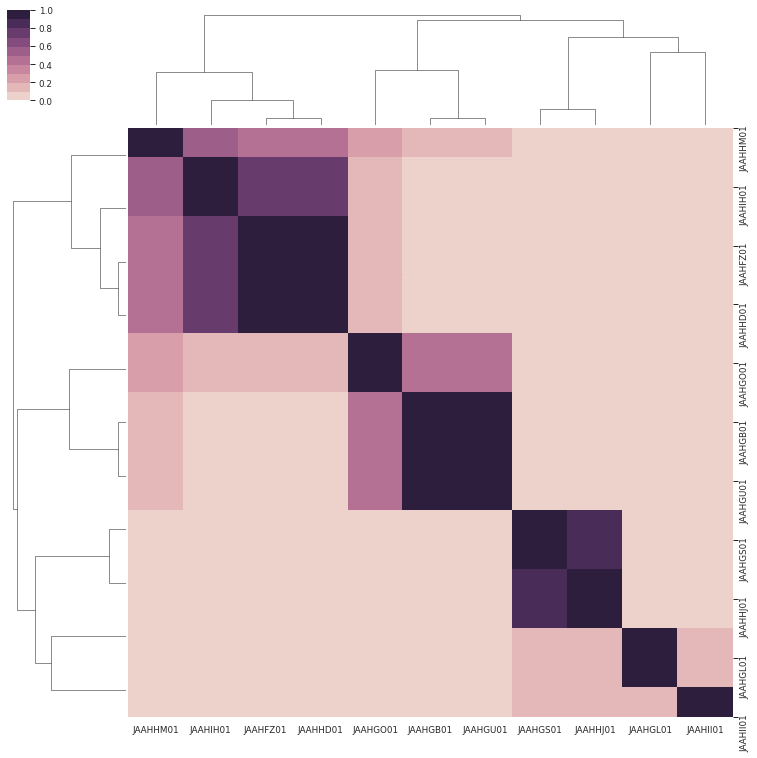

In [67]:
sns.set_context("paper")

correlations = bc_dm_df.corr()
correlations_array = np.asarray(bc_dm_df.corr())

row_linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(distance.pdist(correlations_array.T), method='average')

palette = sns.cubehelix_palette(10)

sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,
               figsize=(13, 13),standard_scale=1,cmap=palette)

print("Jaccard Similarity (0.0-1.0):")

# plt.savefig("./big-scape/outputs/beta-diversity_%s.png"%(int(cutoff*10)),format="png")

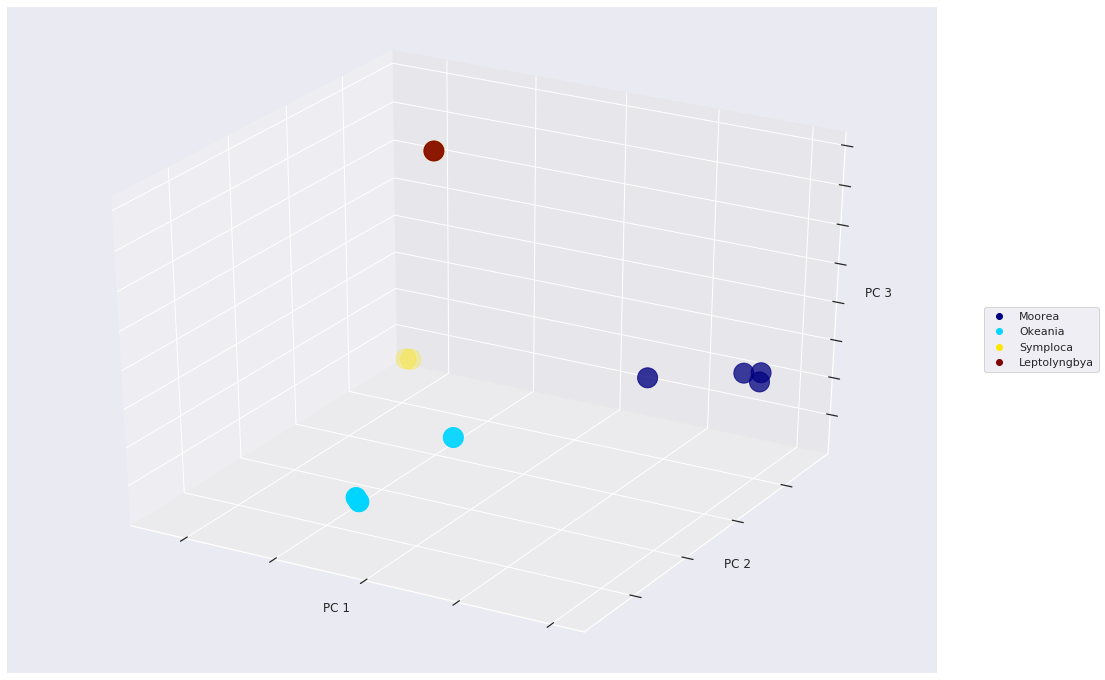

In [39]:
from skbio.stats.ordination import pcoa

bc_pc = pcoa(bc_dm)

fig = bc_pc.plot(sample_md, 'genus', axis_labels=('PC 1', 'PC 2', 'PC 3'), cmap='jet', s=400)

fig.set_size_inches(20, 10)

----

----

----

In [40]:
def get_gnps_df(input_file):
    gnps_df = pd.read_csv(input_file,sep='\t')
    gnps_df.rename(columns=lambda x: re.sub(' ','_',x), inplace=True)
    gnps_df = gnps_df[gnps_df.CLUSTERID1 != gnps_df.CLUSTERID2]
    gnps_df.reset_index(inplace=True,drop=True)
    return gnps_df

gnps_df = get_gnps_df("./inputs/0a4eee3d6e2d476da2dd02d823a98c33..selfloop")

gnps_df[:5]

,CLUSTERID1,CLUSTERID2,DeltaMZ,MEH,Cosine,OtherScore,ComponentIndex,EdgeAnnotation
0,14496,15076,-28.332,14496.0,0.7752,14496.0,1,
1,14198,14224,-0.238,14198.0,0.8203,14198.0,1,
2,14496,15310,-40.985,14496.0,0.8263,14496.0,1,
3,14495,15070,-28.002,14495.0,0.8755,14495.0,1,N2
4,15076,15310,-12.653,15076.0,0.7647,15076.0,1,


In [41]:
def get_family(gerwick_net_pairs,cluster):
    subset_df1 = gerwick_net_pairs[gerwick_net_pairs['CLUSTERID1'] == cluster]
    subset_df2 = gerwick_net_pairs[gerwick_net_pairs['CLUSTERID2'] == cluster]
    frames = [subset_df1, subset_df2]
    gnps_df = pd.concat(frames)
    cluster_family = list(np.unique(list(gnps_df['CLUSTERID1']) + list(gnps_df['CLUSTERID2'])))
    return cluster_family

cluster_list = list(gnps_df['CLUSTERID1']) + list(gnps_df['CLUSTERID2'])
cluster_list = np.unique(cluster_list)

mf_dict = {}
count = 1

for cluster in cluster_list:
    seen = []
    cluster_family = get_family(gnps_df,cluster)
    for item in cluster_family:
        if item not in seen:
            cluster_family = cluster_family + get_family(gnps_df,item)
            cluster_family = list(np.unique(cluster_family))
            seen.append(item)
    while len(seen) < len(cluster_family):
        for item in cluster_family:
            if item not in seen:
                cluster_family = cluster_family + get_family(gnps_df,item)
                cluster_family = list(np.unique(cluster_family))
                seen.append(item)        
    if cluster_family not in mf_dict.values():
        mf_dict['MF%s'%count] = cluster_family
        count += 1

mf_dict

{'MF1': [6, 14],
 'MF2': [30, 34],
 'MF3': [66, 177, 816, 889],
 'MF4': [198, 237, 242],
 'MF5': [486, 498, 508],
 'MF6': [892, 899],
 'MF7': [918,
  1116,
  1125,
  1605,
  1951,
  1958,
  1989,
  1995,
  2045,
  2047,
  2187,
  2570,
  3145,
  3178,
  3181,
  3272,
  3915,
  4241],
 'MF8': [1129,
  1130,
  3852,
  6135,
  6158,
  8185,
  8411,
  8547,
  10573,
  10574,
  11359,
  12259,
  12285,
  12288,
  12322,
  12358,
  12921,
  13570,
  13572,
  13682,
  14277,
  14880,
  14904,
  14918,
  14925,
  14932,
  15501,
  15527,
  15536,
  16094,
  16103,
  16585,
  16588,
  16593,
  16610,
  17109,
  17192,
  17559,
  17565,
  17571,
  17588,
  17963,
  17967,
  18226,
  18679,
  18792,
  18795,
  18807,
  18885,
  18952,
  18972,
  18974,
  18994,
  18996,
  19012,
  19056,
  19077,
  19094],
 'MF9': [1291, 2076],
 'MF10': [1589, 3144, 4321, 5206, 5207, 6276],
 'MF11': [2168, 3730],
 'MF12': [3913, 4877],
 'MF13': [3918,
  7371,
  7831,
  14316,
  14317,
  15331,
  15379,
  15387,
 

In [42]:
nodes_df = pd.read_csv('./inputs/235b14864d87446e909e14250b26bfa1.clustersummary',sep='\t')

nodes_df[:5]

,AllGroups,DefaultGroups,EvenOdd,G1,G2,G3,G4,G5,G6,GNPSLinkout_Cluster,...,SpectrumID,UniqueFileSources,UniqueFileSourcesCount,cluster index,componentindex,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity)
0,,"G2,G3,G4",1,0,4,4,8,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,CCMSLIB00004691416,A1765_015E11_RE11_01_13970.mzXML|1902_024H11_G...,6,6,91,16,137.007,0,137.007,213824.0
1,,"G3,G4",0,0,0,2,3,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,CCMSLIB00004721257,A1837_020A11_GA11_01_14445.mzXML|A1765_015E11_...,2,12,-1,5,141.959,0,141.959,19740.0
2,,"G2,G3,G4",0,0,1,2,2,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,1902_024H11_GH11_01_14948.mzXML|1942_027D9_RD9...,5,14,91,5,145.179,0,145.179,46420.0
3,,"G3,G4",0,0,0,2,2,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,1952_028A5_GA5_01_15275.mzXML|A1765_015E11_RE1...,3,16,-1,4,145.370,0,145.370,50956.0
4,,"G2,G3",0,0,1,1,0,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,1902_024H11_GH11_01_14948.mzXML|A1765_015E11_R...,2,21,-1,2,146.007,0,146.007,15676.0


In [43]:
# cyanobiome_dict = {'ISB03NOV94_8_C_GA6_01_37726.mzXML':'JAAHII01','ASI16JUL14_2_C_GA3_01_37723.mzXML':'JAAHIH01','1902_024H11_GH11_01_14948.mzXML':'JAAHHD01','A1765_015E11_RE11_01_13970.mzXML':'JAAHGB01','2035 cr_GD1_01_37757.mzXML':'JAAHFZ01','A1837_020A11_GA11_01_14445.mzXML':'JAAHHJ01','1952_028A5_GA5_01_15275.mzXML':'JAAHGO01','1942_027D9_RD9_01_15211.mzXML':'JAAHGU01','1716_012E3_GE3_01_13654.mzXML':'JAAHGS01','2103 cr_GE7_01_37775.mzXML':'JAAHHM01','2080 cr_GE2_01_37770.mzXML':'JAAHGL01'}

In [44]:
files_dict = dict(zip(nodes_df['cluster index'],nodes_df['UniqueFileSources']))

In [47]:
cyanobiome_dict = {'JAAHII01':'ISB03NOV94_8_C_GA6_01_37726.mzXML','JAAHIH01':'ASI16JUL14_2_C_GA3_01_37723.mzXML','JAAHHD01':'1902_024H11_GH11_01_14948.mzXML','JAAHGB01':'A1765_015E11_RE11_01_13970.mzXML','JAAHFZ01':'2035 cr_GD1_01_37757.mzXML','JAAHHJ01':'A1837_020A11_GA11_01_14445.mzXML','JAAHGO01':'1952_028A5_GA5_01_15275.mzXML','JAAHGU01':'1942_027D9_RD9_01_15211.mzXML','JAAHGS01':'1716_012E3_GE3_01_13654.mzXML','JAAHHM01':'2103 cr_GE7_01_37775.mzXML','JAAHGL01':'2080 cr_GE2_01_37770.mzXML'}

In [48]:
len(cyanobiome_dict)

11

In [53]:
family_rows = []
indexes = []

for key,value in mf_dict.items():
    indexes.append(key)
    row = []
    files = ''
    for cluster in value:
        files = str(files) + str(files_dict[cluster])
    for strain in cols_to_keep:
        strain_file = cyanobiome_dict[strain]
        if strain_file in files:
            row.append(value)
        else:
            row.append(0)
    family_rows.append(row)

mf_patterns = pd.DataFrame(family_rows,columns=cols_to_keep,index=indexes)

mf_patterns

,JAAHFZ01,JAAHGB01,JAAHGL01,JAAHGO01,JAAHGS01,JAAHGU01,JAAHHD01,JAAHHJ01,JAAHHM01,JAAHIH01,JAAHII01
MF1,0,"[6, 14]",0,"[6, 14]","[6, 14]","[6, 14]","[6, 14]","[6, 14]",0,0,0
MF2,0,"[30, 34]",0,"[30, 34]","[30, 34]","[30, 34]","[30, 34]","[30, 34]",0,0,0
MF3,0,"[66, 177, 816, 889]",0,"[66, 177, 816, 889]","[66, 177, 816, 889]","[66, 177, 816, 889]","[66, 177, 816, 889]","[66, 177, 816, 889]",0,0,0
MF4,0,"[198, 237, 242]",0,"[198, 237, 242]","[198, 237, 242]","[198, 237, 242]","[198, 237, 242]","[198, 237, 242]",0,0,0
MF5,0,"[486, 498, 508]",0,"[486, 498, 508]",0,"[486, 498, 508]","[486, 498, 508]","[486, 498, 508]",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
MF96,0,0,0,0,"[18420, 18443, 18780, 18826, 18948, 19004]",0,0,0,0,0,0
MF97,0,"[18702, 18788, 19083, 19091]",0,0,0,0,0,0,0,0,0
MF98,0,0,0,"[18756, 18783]",0,0,"[18756, 18783]",0,0,0,0
MF99,0,0,0,0,0,"[19076, 19078]","[19076, 19078]","[19076, 19078]",0,0,0


In [59]:
family_counts = []

for i,r in mf_patterns.iterrows():
    new_row = []
    for item in r:
        if item == 0:
            new_row.append(0)
        else:
            new_row.append(1)
    family_counts.append(new_row)
    
mf_binary = pd.DataFrame(family_counts,columns=cols_to_keep,index=indexes)

mf_binary[:5]

,JAAHFZ01,JAAHGB01,JAAHGL01,JAAHGO01,JAAHGS01,JAAHGU01,JAAHHD01,JAAHHJ01,JAAHHM01,JAAHIH01,JAAHII01
MF1,0,1,0,1,1,1,1,1,0,0,0
MF2,0,1,0,1,1,1,1,1,0,0,0
MF3,0,1,0,1,1,1,1,1,0,0,0
MF4,0,1,0,1,1,1,1,1,0,0,0
MF5,0,1,0,1,0,1,1,1,0,0,0


In [60]:
header = list(mf_binary.columns.values)
# gcf_binary.index.names = ['GCFs']

ids = mf_binary.columns.astype(str).tolist()
# data = gcf_binary.as_matrix()
data = mf_binary[cols_to_keep].values
data = data.transpose()
data = data.astype(int)

bc_dm2 = beta_diversity('jaccard', data, ids)
bc_dm_df2 = bc_dm2.to_data_frame()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [61]:
diversity_scores2 = {}

for i,r in bc_dm_df2.iterrows():
    diversity_scores2[i] = np.average(bc_dm_df2[i]),np.std(bc_dm_df2[i])

In [62]:
diversity_scores2

{'JAAHFZ01': (0.6619664621374303, 0.25092799751558303),
 'JAAHGB01': (0.6661668722206094, 0.2858556132079251),
 'JAAHGL01': (0.6832003636600356, 0.3057469778648423),
 'JAAHGO01': (0.6699241047173378, 0.2861707467111636),
 'JAAHGS01': (0.6863866041340073, 0.24683935251983052),
 'JAAHGU01': (0.6126688839793961, 0.27024769523134057),
 'JAAHHD01': (0.619667425963604, 0.2771709296693553),
 'JAAHHJ01': (0.6610096947825972, 0.2985684170925404),
 'JAAHHM01': (0.6509212461071946, 0.25192376333897665),
 'JAAHIH01': (0.6679112542858783, 0.34785710379109175),
 'JAAHII01': (0.6752241318900105, 0.34178084078655135)}

In [64]:
sample_md

,genus
JAAHFZ01,Moorea
JAAHGB01,Okeania
JAAHGL01,Symploca
JAAHGO01,Okeania
JAAHGS01,Symploca
JAAHGU01,Okeania
JAAHHD01,Moorea
JAAHHJ01,Symploca
JAAHHM01,Moorea
JAAHIH01,Moorea


/opt/conda/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.004015567014601418 and the largest is 1.6362670924622211.
  RuntimeWarning


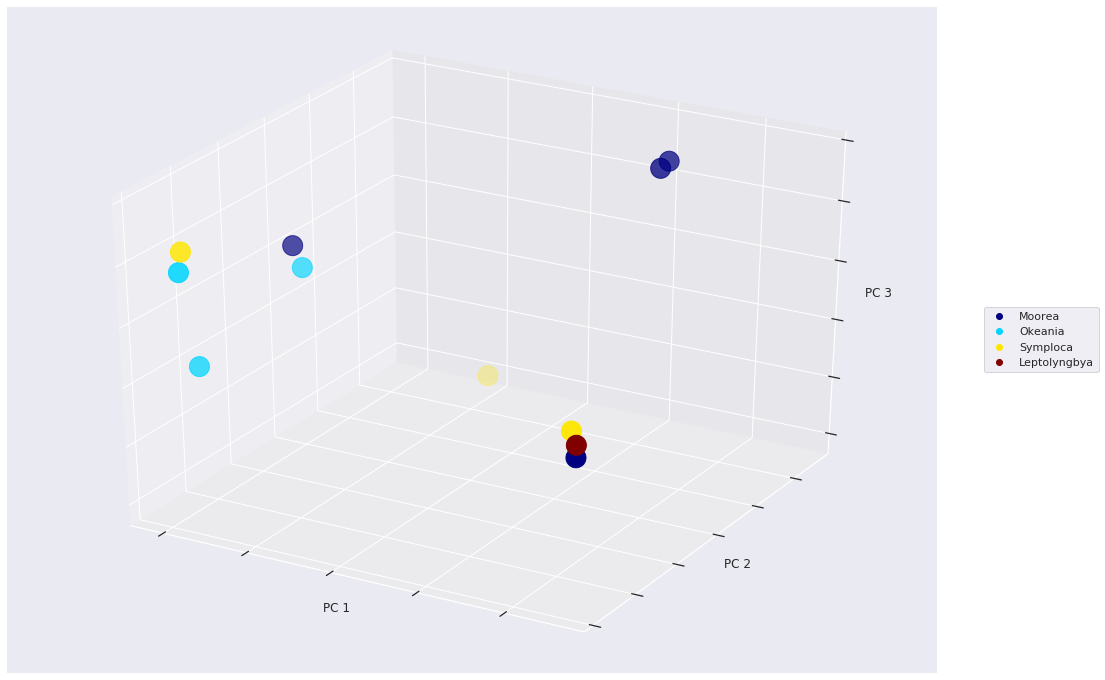

In [65]:
from skbio.stats.ordination import pcoa

bc_pc2 = pcoa(bc_dm2)

fig = bc_pc2.plot(sample_md, 'genus', axis_labels=('PC 1', 'PC 2', 'PC 3'), cmap='jet', s=400)

fig.set_size_inches(20, 10)

Jaccard Similarity (0.0-1.0):


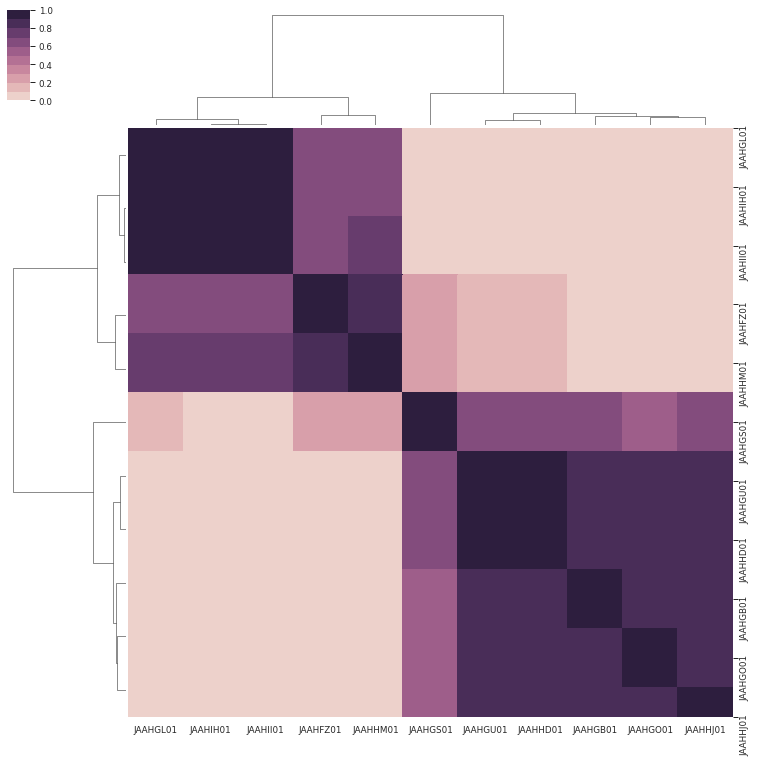

In [66]:
sns.set_context("paper")

correlations = bc_dm_df2.corr()
correlations_array = np.asarray(bc_dm_df2.corr())

row_linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(distance.pdist(correlations_array.T), method='average')

palette = sns.cubehelix_palette(10)

sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,
               figsize=(13, 13),standard_scale=1,cmap=palette)

print("Jaccard Similarity (0.0-1.0):")

# plt.savefig("./big-scape/outputs/beta-diversity_%s.png"%(int(cutoff*10)),format="png")

In [69]:
metadata_df = pd.read_csv("./cyanobiome_metadata_df-TFL200507.tsv",sep='\t',index_col=0)

taxa_dict = dict(zip(metadata_df['GenomeID'],metadata_df['Taxa']))

new_cols = []

for item in mf_binary.columns:
    new_name = taxa_dict[item] + ' sp. ' + item
    new_cols.append(new_name)
    
mf_binary.columns = new_cols

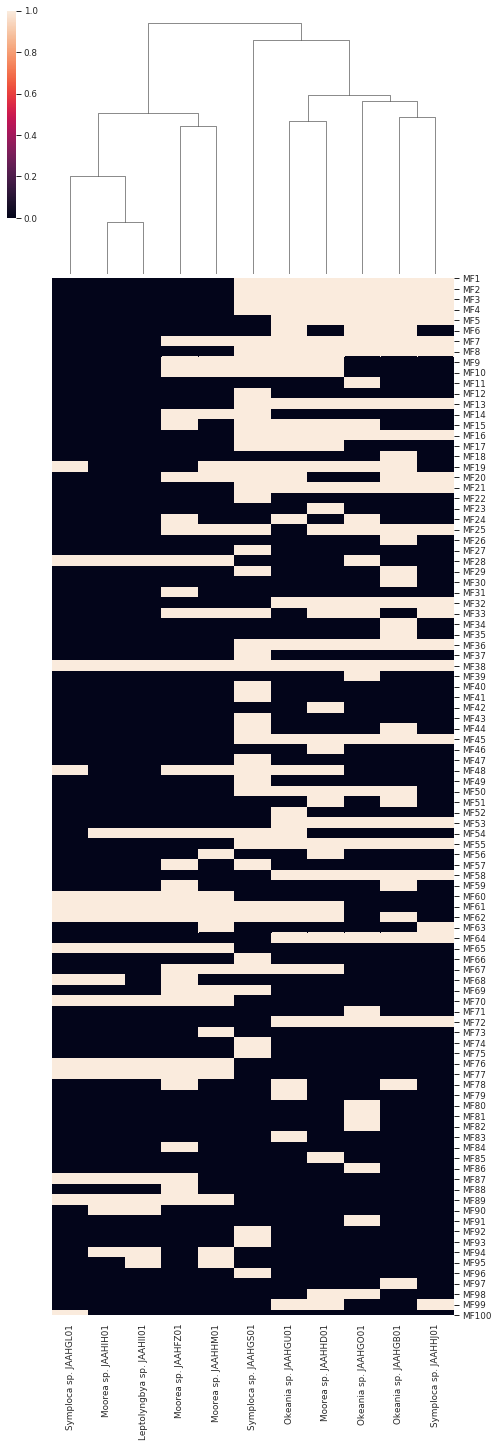

In [71]:
sns.clustermap(mf_binary,row_cluster=False,figsize=(8,24))

In [74]:
mf_patterns.loc['MF38']

JAAHFZ01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHGB01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHGL01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHGO01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHGS01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHGU01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHHD01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHHJ01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHHM01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHIH01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
JAAHII01    [9882, 14197, 14198, 14224, 14495, 14496, 1507...
Name: MF38, dtype: object

In [81]:
for item in mf_patterns.loc['MF38'][0]:
    print(nodes_df[nodes_df['cluster index'] == item]['LibraryID'])

498    NaN
Name: LibraryID, dtype: object
902    Sarmentoside B
Name: LibraryID, dtype: object
903    NaN
Name: LibraryID, dtype: object
906    Sarmentoside B
Name: LibraryID, dtype: object
930    NaN
Name: LibraryID, dtype: object
931    NaN
Name: LibraryID, dtype: object
982    NaN
Name: LibraryID, dtype: object
983    NaN
Name: LibraryID, dtype: object
984    NaN
Name: LibraryID, dtype: object
1010    NaN
Name: LibraryID, dtype: object


**TODO**
```
- Include BGCs only from the proper strain in mf_patterns cells
```